In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from scipy.stats import vonmises  #for von Mises distribution
import scipy.optimize   #for log-likelihood

import seaborn as sns
sns.set_style("white")
sns.set_context("paper")
plt.ion()
from pybasicbayes.util.text import progprint_xrange

from pyglm.utils.basis import cosine_basis
from pyglm.plotting import plot_glm
from pyglm.models import SparseBernoulliGLM


% matplotlib inline

### Bayesian inference for GLM to analyze network structure from activity

https://github.com/slinderman/pyglm

-Simulated neural activity in a small neural network and inferr the connections and weights

-This inverse problem is formulated in a Baysien framework with prior on network struture

In [179]:
### Generate neural activity in a small network
T = 10000   # Number of time bins to generate
N = 5       # Number of neurons
B = 1       # Number of "basis functions"
L = 100     # Autoregressive window of influence
tau = 10
dt = 1
R = np.zeros((T,N))
S = np.zeros((T,N))
R[0,:] = np.random.randn(N)
S[0,:] = np.random.randint(2,size=N)
A = np.random.randint(2,size=(N,N))
W = np.random.randn(N,N)
def logistic_function(phi):
    return np.exp(phi)/(1+np.exp(phi))
for tt in range(0,T-1):
    R[tt+1,:] = R[tt,:] + dt*(-(1/tau)*R[tt,:] + np.dot(np.multiply(A,W),S[tt,:]))
    temp = np.zeros(N)
    temp[logistic_function(R[tt+1,:])>np.random.rand(N)] = 1
    S[tt+1,:] = temp

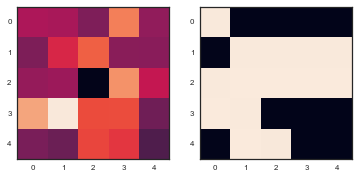

In [180]:
plt.subplot(121)
plt.imshow(W,interpolation='none')
plt.subplot(122)
plt.imshow(A,interpolation='none')

.........................  [  25/200,    0.04sec avg, ETA 6.76 ]
.........................  [  50/200,    0.04sec avg, ETA 5.59 ]
.........................  [  75/200,    0.04sec avg, ETA 4.69 ]
.........................  [ 100/200,    0.04sec avg, ETA 3.76 ]
.........................  [ 125/200,    0.04sec avg, ETA 2.76 ]
.........................  [ 150/200,    0.04sec avg, ETA 1.80 ]
.........................  [ 175/200,    0.04sec avg, ETA 0.90 ]
.........................  [ 200/200,    0.04sec avg, ETA 0.00 ]

   0.04sec avg, 7.13 total



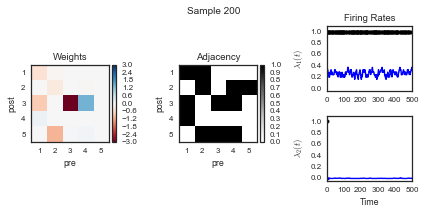

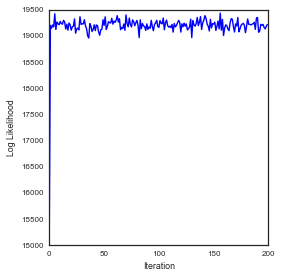

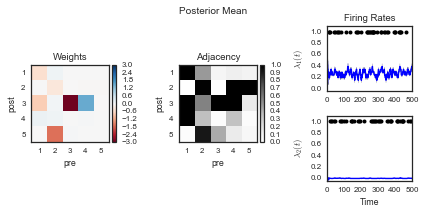

In [189]:
from pyglm.models import SparseGaussianGLM

# Create a cosine basis to model smooth influence of
# spikes on one neuron on the later spikes of others.
B = 1       # Number of "basis functions"
L = 10     # Autoregressive window of influence
basis = cosine_basis(B=B, L=L) / L

# # Generate some data from a model with self inhibition
# true_model = \
#     SparseBernoulliGLM(N, basis=basis,
#                        regression_kwargs=dict(S_w=10.0, mu_b=-2.))
# for n in range(N):
#     true_model.regressions[n].a[n] = True    #rate a
#     true_model.regressions[n].W[n,:] = -2.0  #connectivity W:j
# _, Y = true_model.generate(T=T, keep=True)

# # Plot the true model
# fig, axs, handles = true_model.plot()
# plt.pause(0.1)

# Create a test model for fitting
# test_model = \
#     SparseBernoulliGLM(N, basis=basis,
#                        regression_kwargs=dict(S_w=10.0, mu_b=-2.))
test_model = \
    SparseGaussianGLM(N, basis=basis,
                       regression_kwargs=dict(S_w=10.0, mu_b=-2.))

test_model.add_data(S)

# Plot the test model
fig, axs, handles = test_model.plot(title="Sample 0")
plt.pause(0.1)

# Fit with Gibbs sampling
def _collect(m):
    return m.log_likelihood(), m.weights, m.adjacency, m.biases, m.means[0]

def _update(m, itr):
    m.resample_model()
    test_model.plot(handles=handles,
                    pltslice=slice(0, 500),
                    title="Sample {}".format(itr+1))
    return _collect(m)

N_samples = 200
samples = []
for itr in progprint_xrange(N_samples):
    samples.append(_update(test_model, itr))

# Unpack the samples
samples = zip(*samples)
lps, W_smpls, A_smpls, b_smpls, fr_smpls = tuple(map(np.array, samples))

# Plot the log likelihood per iteration
fig = plt.figure(figsize=(4,4))
plt.plot(lps)
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")
plt.tight_layout()

# Plot the posterior mean and variance
W_mean = W_smpls[N_samples//2:].mean(0)
A_mean = A_smpls[N_samples//2:].mean(0)
fr_mean = fr_smpls[N_samples//2:].mean(0)
fr_std = fr_smpls[N_samples//2:].std(0)

fig, _, _ = plot_glm(Y, W_mean, A_mean, fr_mean,
                     std_firingrates=3*fr_std, title="Posterior Mean")

plt.show()

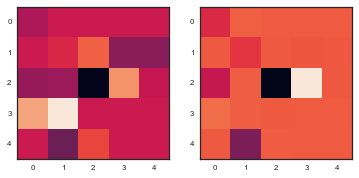

In [190]:
#effective coupling
plt.subplot(121)
plt.imshow(np.multiply(A,W),interpolation='none')
plt.subplot(122)
plt.imshow(np.multiply(A_mean,np.squeeze(W_mean)),interpolation='none')

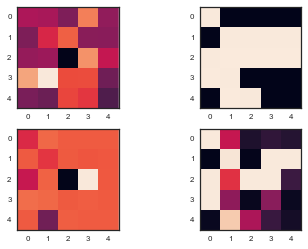

In [191]:
plt.subplot(221)
plt.imshow(W,interpolation='none')
plt.subplot(222)
plt.imshow(A,interpolation='none')
plt.subplot(223)
plt.imshow(np.squeeze(W_mean),interpolation='none')
plt.subplot(224)
plt.imshow(A_mean,interpolation='none')